In [ ]:
import ray
ray.shutdown()
ray.init(num_cpus=8)

debug = False
CMDP_type = "streaming"  # choose "random" or "streaming"
NUM_SEEDS = 10
# NUM_SEEDS = 3

record_resol = 100  # regret is recorded every 100 steps

2025-08-16 09:49:45,581	INFO worker.py:1888 -- Started a local Ray instance.


(run_proposal pid=397032) WARNING:2025-08-16 09:49:46,675:jax._src.xla_bridge:909: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
100%|██████████| 100/100 [00:01<00:00, 74.97it/s]
(run_Ghosh pid=397564) WARNING:2025-08-16 09:49:46,938:jax._src.xla_bridge:909: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu. [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
100%|██████████| 3000/3000 [01:34<00:00, 31.65it/s]


In [2]:
from envs.cmdp import CMDP

if CMDP_type == "random":
    from envs.tabular import create_cmdp as _create_cmdp
    create_cmdp = lambda key, **args: _create_cmdp(key, S=10, A=3, H=15, const_scale=0.6)
elif CMDP_type == "streaming":
    from envs.streaming import create_cmdp
elif CMDP_type == "linear":
    from envs.linear import create_cmdp as _create_cmdp
    d, H = 10, 5
    create_cmdp = lambda key, **args: _create_cmdp(key, S=80, A=5, d=d, H=H, const_scale=0.8)

In [3]:
# Hyperparameters

if CMDP_type == "random":
    Cr = 10.0
    Cu = 10.0
    Cd = 1
    Clam = 300
    Bd = 1.0
    ent_coef = 0.1
    K = 300000  # number of episodes

elif CMDP_type == "streaming":
    Cr = 5.0
    Cu = 5.0
    Cd = 1
    Clam = 300
    Bd = 1.0
    ent_coef = 0.1
    K = 300000  # number of episodes

elif CMDP_type == "linear":
    Cr = 8.0
    Cu = 8.0
    Cd = 1.0
    Clam = 1000
    Bd = 1.0
    ent_coef = 0.01
    K = 100000  # number of episodes

# Proposed Algorithm (Algorithm 2)

In [4]:
import jax
from jax.random import PRNGKey
import jax.numpy as jnp
import numpy as np
from tqdm import tqdm
from utils import sample_and_compute_regret, Sherman_Morrison_update_H, compute_bonus, update_ephi_sum_and_estimate_P
from proposal import bisection_search_lam, compute_softmax_pol


@jax.jit
def update(_, args):
    args1, args2, args3= args
    regret, vio_regret, safe_deploy_sum = args1
    key, pol, cmdp, Lambda_inv, ephi_sum = args2
    lam_range = args3

    H, S, A = cmdp.rew.shape
    d = cmdp.d

    # Cr = Cr_coef * d * H
    # Cu = Cu_coef * d * H
    # Cd = Cd_coef * d ** 2 * H ** 3 / cmdp.xi

    key, traj, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)

    # ===== compute bonus function =====
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    Lambda_inv = Sherman_Morrison_update_H(Lambda_inv, Phi)
    bonus = compute_bonus(Lambda_inv, cmdp)  # (H x S x A)

    # ===== compute estimated P =====
    ephi_sum, est_P = update_ephi_sum_and_estimate_P(ephi_sum, Lambda_inv, traj, cmdp)

    # ===== search sufficiently small lambda =====
    est_cmdp = cmdp._replace(P=est_P)
    lam_range = bisection_search_lam(est_cmdp, bonus, ent_coef, Cr, Cd, Cu, Bd, Clam, 20)
    util, pol = compute_softmax_pol(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cd, Cu, Bd)

    pol = jax.lax.cond(util < cmdp.const, lambda: cmdp.safe_policy, lambda: pol)
    is_safe_deployed = util < cmdp.const

    regret = regret + err_rew
    vio_regret = vio_regret + err_vio
    safe_deploy_sum = safe_deploy_sum + is_safe_deployed
    return (regret, vio_regret, safe_deploy_sum), (key, pol, cmdp, Lambda_inv, ephi_sum), (lam_range, util - cmdp.const)


@jax.jit
def multiple_updates(args):
    return jax.lax.fori_loop(0, record_resol, update, args)


def RunAlgo(cmdp: CMDP, iteration: int, seed):
    key = PRNGKey(seed)
    H, S, A = cmdp.rew.shape
    d = cmdp.d

    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.inv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    episodes = []
    regrets = []
    vio_regrets = []
    safe_deploy_sums = []

    pol = cmdp.safe_policy
    args = (0, 0, 0), (key, pol, cmdp, Lambda_inv, ephi_sum), (jnp.array([0.0, Clam]),)  # initial values
    epi_sum = 0

    # Record the initial results
    for _ in tqdm(range(record_resol)):
        args = update(0, args)
        (regret, vio_regret, safe_deploy_sum), _, (lam_range, est_vio) = args
        # print(lam_range, est_vio)
        epi_sum += 1
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)
        safe_deploy_sums.append(safe_deploy_sum)

    for _ in tqdm(range(int(iteration / record_resol))):
        args = multiple_updates(args)
        (regret, vio_regret, safe_deploy_sum), _, (lam_range, est_vio) = args
        # print(lam_range, est_vio)

        epi_sum += record_resol
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)
        safe_deploy_sums.append(safe_deploy_sum)
    return np.array(episodes), np.array(regrets), np.array(vio_regrets), np.array(safe_deploy_sums)

# Ghosh[2024]'s Algorithm

In [5]:
from Ghosh_algo import compute_softmax_pol_Ghosh, bisection_search_lam_Ghosh


@jax.jit
def update_Ghosh(k, args):
    args1, args2 = args
    regret, vio_regret = args1
    key, pol, cmdp, Lambda_inv, ephi_sum = args2

    key, traj, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)

    # ===== compute bonus function =====
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    Lambda_inv = Sherman_Morrison_update_H(Lambda_inv, Phi)
    bonus = compute_bonus(Lambda_inv, cmdp)  # (H x S x A)

    # ===== compute estimated P =====
    ephi_sum, est_P = update_ephi_sum_and_estimate_P(ephi_sum, Lambda_inv, traj, cmdp)

    # ===== search sufficiently small lambda =====
    est_cmdp = cmdp._replace(P=est_P)
    lam_range = bisection_search_lam_Ghosh(est_cmdp, bonus, ent_coef, Cr, Cu, Clam, 20)
    _, pol = compute_softmax_pol_Ghosh(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cu)

    regret = regret + err_rew
    vio_regret = vio_regret + err_vio
    return (regret, vio_regret), (key, pol, cmdp, Lambda_inv, ephi_sum)


@jax.jit
def multiple_updates_Ghosh(args):
    return jax.lax.fori_loop(0, record_resol, update_Ghosh, args)


def RunAlgoGhosh(cmdp: CMDP, iteration: int, seed):
    key = PRNGKey(seed)
    H, S, A = cmdp.rew.shape
    d = cmdp.d

    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    episodes = []
    regrets = []
    vio_regrets = []

    pol = cmdp.safe_policy

    args = (0.0, 0.0), (key, pol, cmdp, Lambda_inv, ephi_sum)
    epi_sum = 0

    # Record the initial results
    for _ in tqdm(range(record_resol)):
        args = update_Ghosh(0, args)
        (regret, vio_regret), _ = args
        epi_sum += 1
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)

    for _ in tqdm(range(int(iteration / record_resol))):
        args = multiple_updates_Ghosh(args)
        (regret, vio_regret), _ = args

        epi_sum += record_resol
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)
    return np.array(episodes), np.array(regrets), np.array(vio_regrets)

# Uniform policy

In [6]:
def RunUniPolicy(cmdp: CMDP, iteration: int, seed):

    H, S, A = cmdp.rew.shape
    pol = jnp.ones((H, S, A)) / A
    key = PRNGKey(seed)  # dummy. computing temporal regret does not require randomness here.
    key, _, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)

    errors_rew = [err_rew] * int(iteration / record_resol)
    regrets = np.cumsum(errors_rew) * record_resol
    errors_vio = [np.maximum(err_vio, 0)] * int(iteration / record_resol)
    vio_regrets = np.cumsum(errors_vio) * record_resol
    episodes = np.arange(int(iteration / record_resol)) * record_resol + 1
    return np.array(episodes), np.array(regrets), np.array(vio_regrets)

# Run Algorithms

In [7]:
import ray
from utils import set_cmdp_info


@ray.remote
class Buffer:
    def __init__(self):
        self.episodes = []
        self.regrets = []
        self.vio_regrets = []
        self.safe_deploy_sums = []

        self.episodes_Ghosh = []
        self.regrets_Ghosh = []
        self.vio_regrets_Ghosh = []

        self.episodes_uni = []
        self.regrets_uni = []
        self.vio_regrets_uni = []

    def add_proposal(self, episodes, regrets, vio_regrets, safe_deploy_sums):
        self.episodes.append(episodes)
        self.regrets.append(regrets)
        self.vio_regrets.append(vio_regrets)
        self.safe_deploy_sums.append(safe_deploy_sums)

    def add_Ghosh(self, episodes_Ghosh, regrets_Ghosh, vio_regrets_Ghosh):
        self.episodes_Ghosh.append(episodes_Ghosh)
        self.regrets_Ghosh.append(regrets_Ghosh)
        self.vio_regrets_Ghosh.append(vio_regrets_Ghosh)

    def add_uni(self, episodes_uni, regrets_uni, vio_regrets_uni):
        self.episodes_uni.append(episodes_uni)
        self.regrets_uni.append(regrets_uni)
        self.vio_regrets_uni.append(vio_regrets_uni)

    def get(self):
        episodes = np.array(self.episodes)
        regrets = np.array(self.regrets)
        vio_regrets = np.array(self.vio_regrets)
        deploy_sums = np.array(self.safe_deploy_sums)

        Ghosh_episodes = np.array(self.episodes_Ghosh)
        Ghosh_regrets = np.array(self.regrets_Ghosh)
        Ghosh_vio_regrets = np.array(self.vio_regrets_Ghosh)

        uni_episodes = np.array(self.episodes_uni)
        uni_regrets = np.array(self.regrets_uni)
        uni_vio_regrets = np.array(self.vio_regrets_uni)

        return episodes, regrets, vio_regrets, deploy_sums, Ghosh_episodes, Ghosh_regrets, Ghosh_vio_regrets, uni_episodes, uni_regrets, uni_vio_regrets


@ray.remote
def run_proposal(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes, regrets, vio_regrets, safe_deploy_sums = RunAlgo(cmdp, K, seed)

    buffer.add_proposal.remote(
        np.array(episodes),
        np.array(regrets),
        np.array(vio_regrets),
        np.array(safe_deploy_sums),
    )


@ray.remote
def run_Ghosh(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes_Ghosh, regrets_Ghosh, vio_regrets_Ghosh = RunAlgoGhosh(cmdp, K, seed)

    buffer.add_Ghosh.remote(
        np.array(episodes_Ghosh),
        np.array(regrets_Ghosh),
        np.array(vio_regrets_Ghosh),
    )


@ray.remote
def run_uni(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes_uni, regrets_uni, vio_regrets_uni = RunUniPolicy(cmdp, K, seed)

    buffer.add_uni.remote(
        np.array(episodes_uni),
        np.array(regrets_uni),
        np.array(vio_regrets_uni)
    )


buffer = Buffer.remote()

jobs = []
for i in range(NUM_SEEDS):
    jobs.append(run_proposal.remote(buffer, i))
    jobs.append(run_Ghosh.remote(buffer, i))
    jobs.append(run_uni.remote(buffer, i))

_ = ray.get(jobs)

In [8]:
import pickle

with open(f"results-{CMDP_type}.pkl", "wb") as f:
    results = ray.get(buffer.get.remote())
    pickle.dump(results, f)

In [9]:
import pickle
with open(f"results-{CMDP_type}.pkl", "rb") as f:
    results = pickle.load(f)
    episodes, regrets, vio_regrets, deploy_sums, Ghosh_episodes, Ghosh_regrets, Ghosh_vio_regrets, uni_episodes, uni_regrets, uni_vio_regrets = results

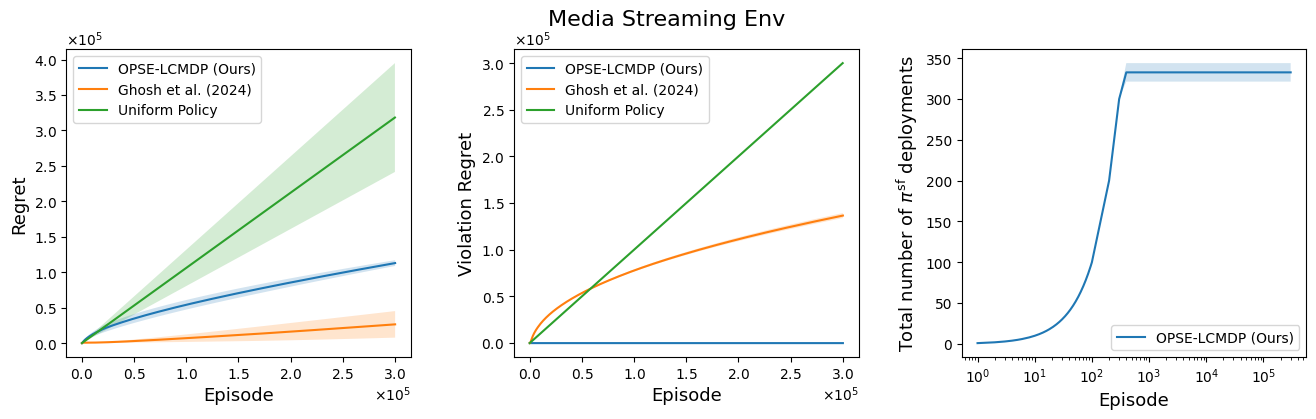

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


class FixedOrderFormatter(ScalarFormatter):
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=True):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        self.orderOfMagnitude = self._order_of_mag


# Compute mean and std
epi_mean = episodes.mean(axis=0)
reg_mean, reg_std = regrets.mean(axis=0), regrets.std(axis=0)
vio_mean, vio_std = vio_regrets.mean(axis=0), vio_regrets.std(axis=0)
deploy_mean, deploy_std = deploy_sums.mean(axis=0), deploy_sums.std(axis=0)

Ghosh_epi_mean = Ghosh_episodes.mean(axis=0)
Ghosh_reg_mean, Ghosh_reg_std = Ghosh_regrets.mean(axis=0), Ghosh_regrets.std(axis=0)
Ghosh_vio_mean, Ghosh_vio_std = Ghosh_vio_regrets.mean(axis=0), Ghosh_vio_regrets.std(axis=0)

uni_epi_mean = uni_episodes.mean(axis=0)
uni_reg_mean, uni_reg_std = uni_regrets.mean(axis=0), uni_regrets.std(axis=0)
uni_vio_mean, uni_vio_std = uni_vio_regrets.mean(axis=0), uni_vio_regrets.std(axis=0)


# Plot with std bars
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.3)

# Plot cumulative reward
ax = fig.add_subplot(1, 3, 1)
ax.plot(epi_mean, reg_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax.fill_between(epi_mean, reg_mean - reg_std, reg_mean + reg_std, alpha=0.2)
ax.plot(Ghosh_epi_mean, Ghosh_reg_mean, label="Ghosh et al. (2024)", rasterized=True)
ax.fill_between(Ghosh_epi_mean, Ghosh_reg_mean - Ghosh_reg_std, Ghosh_reg_mean + Ghosh_reg_std, alpha=0.2)
ax.plot(uni_epi_mean, uni_reg_mean, label="Uniform Policy", rasterized=True)
ax.fill_between(uni_epi_mean, uni_reg_mean - uni_reg_std, uni_reg_mean + uni_reg_std, alpha=0.2)

ax.set_ylabel("Regret", fontdict={"fontsize": 13})
ax.set_xlabel("Episode", fontdict={"fontsize": 13})
ax.legend()
ax.yaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax.xaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))
ax.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))

# Plot cumulative violations
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(epi_mean, vio_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax2.fill_between(epi_mean, vio_mean - vio_std, vio_mean + vio_std, alpha=0.2)
ax2.plot(Ghosh_epi_mean, Ghosh_vio_mean, label="Ghosh et al. (2024)", rasterized=True)
ax2.fill_between(Ghosh_epi_mean, Ghosh_vio_mean - Ghosh_vio_std, Ghosh_vio_mean + Ghosh_vio_std, alpha=0.2)
ax2.plot(uni_epi_mean, uni_vio_mean, label="Uniform Policy", rasterized=True)
ax2.fill_between(uni_epi_mean, uni_vio_mean - uni_vio_std, uni_vio_mean + uni_vio_std, alpha=0.2)
ax2.set_ylabel("Violation Regret", fontdict={"fontsize": 13})
ax2.set_xlabel("Episode", fontdict={"fontsize": 13})
ax2.legend()
ax2.yaxis.set_major_formatter(FixedOrderFormatter(6 ,useMathText=True))
ax2.xaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax2.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))
ax2.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))

# plot number of safe policy deployments
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(epi_mean, deploy_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax3.fill_between(epi_mean, deploy_mean - deploy_std, deploy_mean + deploy_std, alpha=0.2)
ax3.set_ylabel(r"Total number of $\pi^{\mathrm{sf}}$ deployments", fontdict={"fontsize": 13})
ax3.set_xlabel("Episode", fontdict={"fontsize": 13})
ax3.set_xscale("log")
ax3.legend()

if CMDP_type == "random":
    plt.suptitle(f"Synthetic Tabular Env", fontsize=16)
elif CMDP_type == "streaming":
    plt.suptitle(f"Media Streaming Env", fontsize=16)
elif CMDP_type == "linear":
    plt.suptitle(f"Synthetic Linear Env", fontsize=16)

# plt.tight_layout()
plt.savefig(f"results-{CMDP_type}.pdf")